### Importing necessary libraries and files

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


### Preprocessing

In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


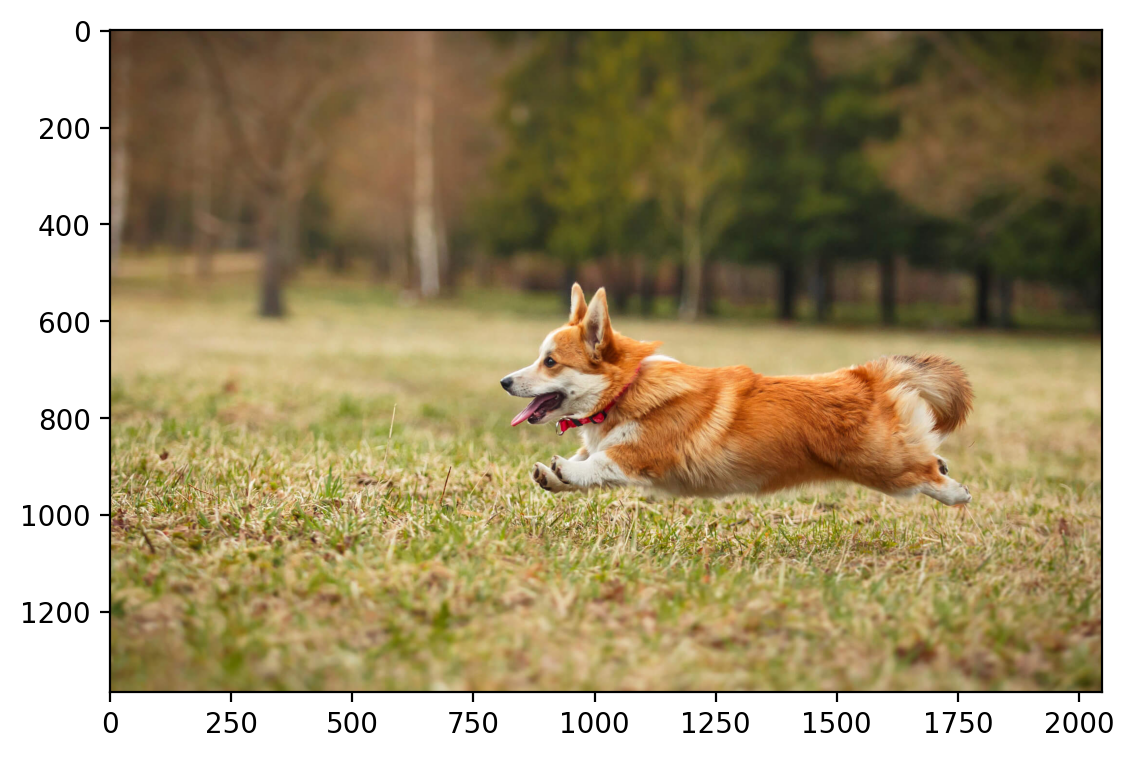

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

### Original Image 400*400

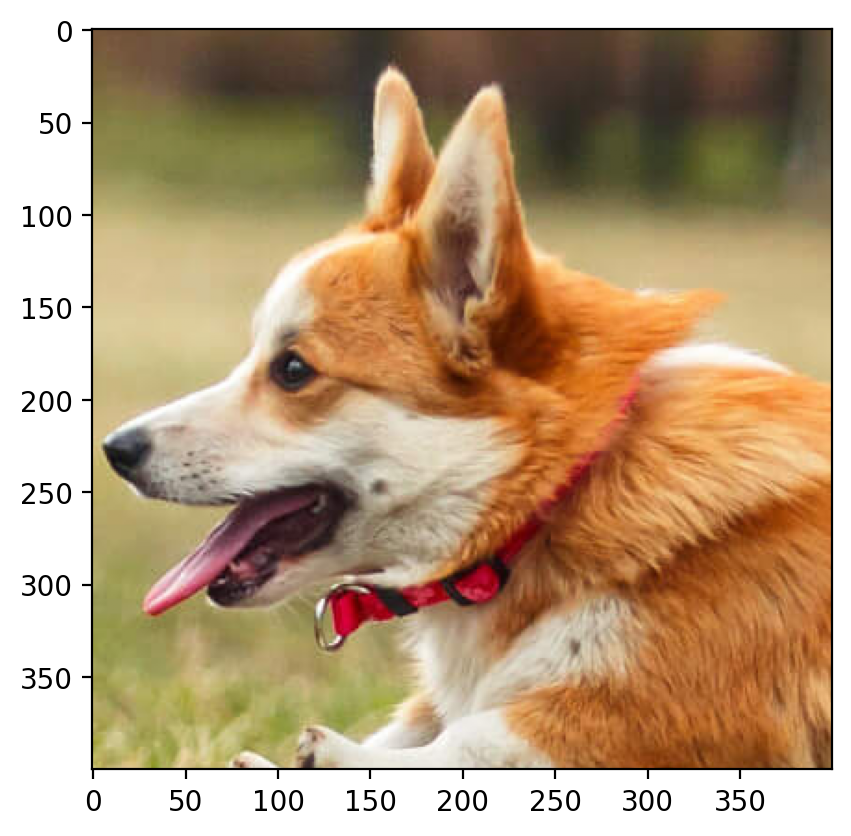

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [10]:
crop = crop.to(device)
crop.shape

torch.Size([3, 400, 400])

### Resized to 200*200

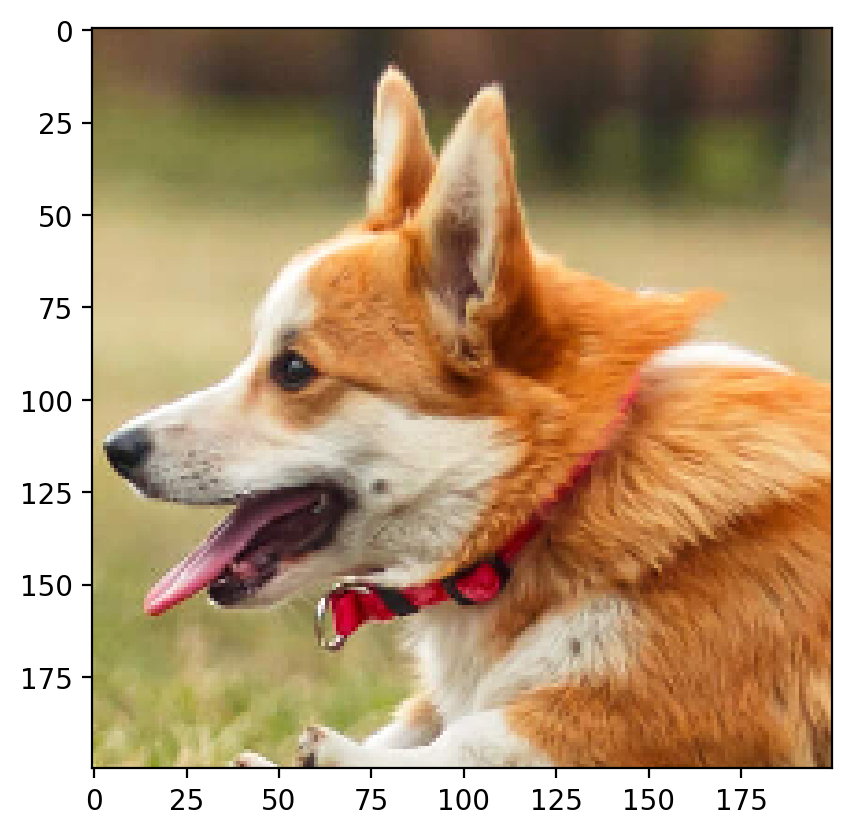

In [11]:
from torch.nn.functional import interpolate
rcrop = interpolate(crop.unsqueeze(0), size=(200, 200), mode='nearest').squeeze(0)
plt.imshow(rearrange(rcrop, 'c h w -> h w c').cpu().numpy())

In [12]:
num_channels, height, width = rcrop.shape
print(num_channels, height, width)

3 200 200


### Linear Model

In [13]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x)

In [14]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

### Creating coordinate map

In [15]:
num_channels, height, width = 2, 3, 4
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)
X = torch.stack([h_coords, w_coords], dim=1).float()
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    X = torch.stack([h_coords, w_coords], dim=1).float()
    X = X.to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
dog_X, dog_Y = create_coordinate_map(rcrop)
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [16]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

### RFF Function Creation

In [17]:
f_no = 10000
sigma = 0.02

In [18]:
def create_rff_features(X, num_features, sigma, random_seed=190):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np
    np.random.seed(random_seed)
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=random_seed)
    X = X.cpu().numpy()
    X_rff = rff.fit_transform(X)
    return torch.tensor(X_rff, dtype=torch.float32).to(device)
X_rff = create_rff_features(dog_X_scaled, f_no, sigma)

### Model Training

In [19]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 200)

Epoch 0 loss: 0.319005
Epoch 100 loss: 0.024179


0.0028956837486475706

### Prediction

The following function takes the scale of super-resolution and outputs super-resolved image

In [20]:
def PredPlot(coor_scale, orig_img, net):
    chann,height,width = orig_img.shape
    coords = np.array([[i/coor_scale, j/coor_scale] for i in range(width*coor_scale) for j in range(width*coor_scale)])
    Xten = torch.tensor(coords)
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(Xten.cpu())
    Xten_scaled = scaler_X.transform(Xten.cpu())
    Xten_scaled = torch.tensor(Xten_scaled).to(device)
    Xten_scaled = Xten_scaled.float()
    X = create_rff_features(Xten_scaled, f_no, sigma)
    num_channels, height, width = orig_img.shape
    height*=coor_scale; width*=coor_scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax0.imshow(outputs.cpu())
    ax0.set_title(f"Reconstructed Image {outputs.shape}")
    ax1.imshow(orig_img.cpu().permute(1, 2, 0))
    ax1.set_title(f"Original Resized Image {rcrop.shape}")
    ax2.imshow(crop.permute(1, 2, 0))
    ax2.set_title(f"Original Image {crop.shape}")
    for a in [ax0, ax1, ax2]:
        a.axis("off")
    fig.suptitle("", y=0.9)
    plt.tight_layout()
    plt.show()
    return outputs.cpu()

### Trained on (200 * 200) resized image and prediction on  (200 * 200) image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


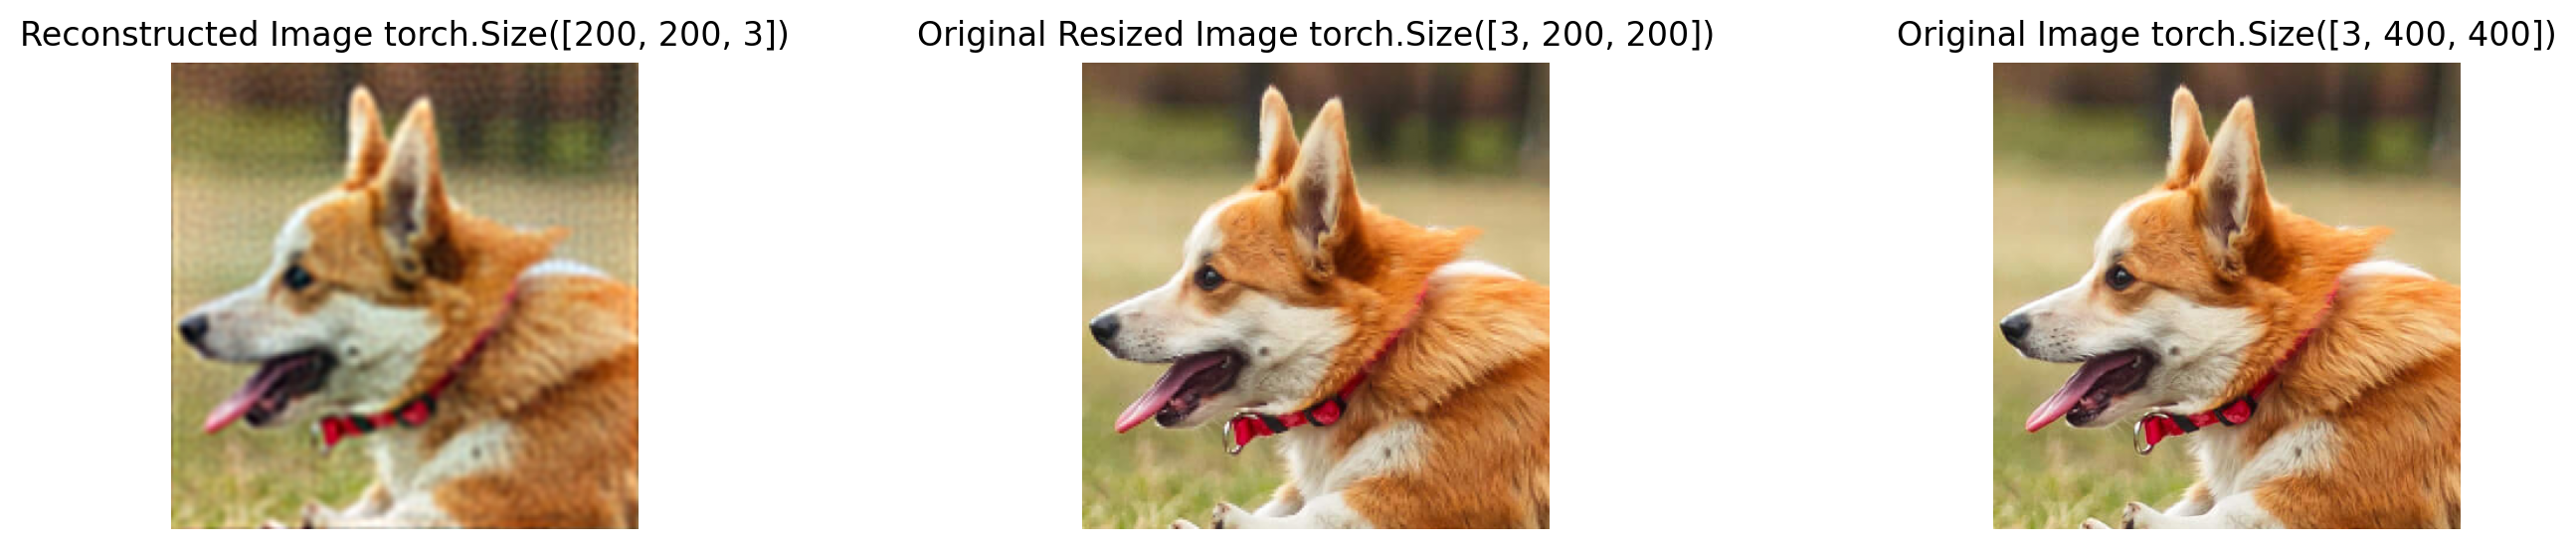

In [21]:
fimg1  = PredPlot(1,rcrop,net)

## Super-resolution

### Trained on (200 * 200) resized image and prediction on  (400 * 400) image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


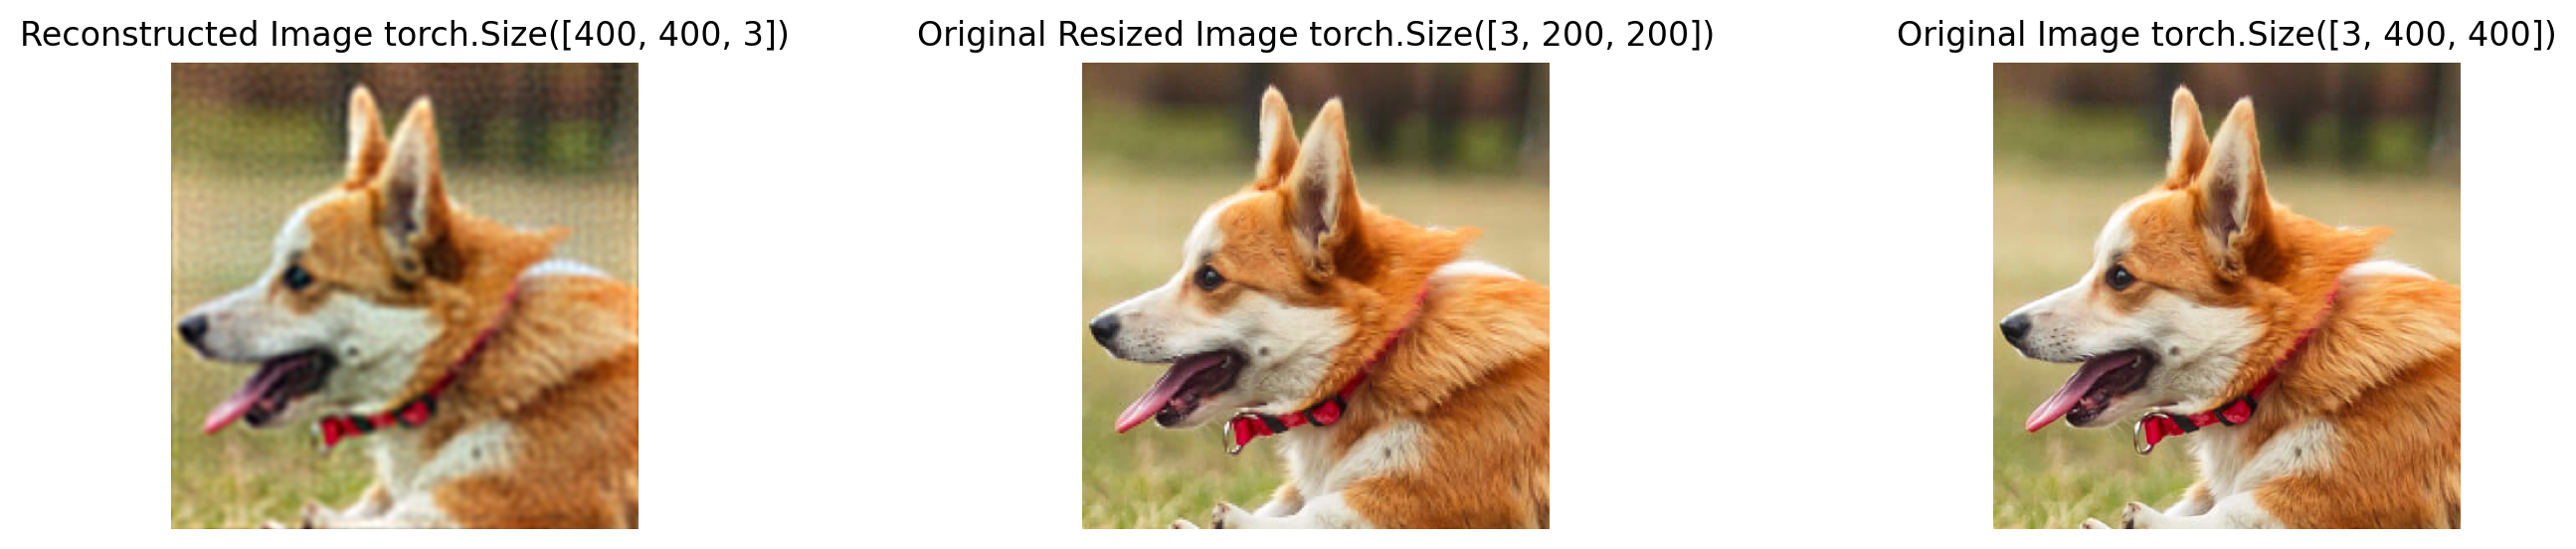

In [22]:
final_image  = PredPlot(2,rcrop,net)

In [23]:
import torch
import torch.nn.functional as F

final_image = final_image.float()
ground_truth = crop.permute(1,2,0)
ground_truth = ground_truth.float()

rmse = torch.sqrt(F.mse_loss(final_image, ground_truth))

max_pixel_value = 1.0
mse = F.mse_loss(final_image, ground_truth)
psnr = 10 * torch.log10((max_pixel_value**2) / mse)

print("RMSE:", rmse.item())
print("PSNR:", psnr.item())

RMSE: 0.054857462644577026
PSNR: 25.21528434753418








**Interpretation**:

**RMSE**: This value is relatively low, suggesting that the predicted high-resolution image is quite close to the original high-resolution image in terms of pixel values. The lower the RMSE, the smaller the error between the predicted and the original images, indicating a high degree of accuracy in the super-resolution process. This suggests that the model was effective in capturing the essential details during the upscaling process.

**PSNR**: The PSNR value falls within a moderate range. In the context of image processing, a PSNR of above 20 dB can be considered acceptable for many applications, though higher values (e.g., above 30 dB) are often desired for high-quality reconstructions. The PSNR value indicates that the model has managed to upscale the image with a reasonable level of quality retention, but there are noticeable differences from the original high-resolution image, especially in terms of noise and detail preservation.

**Inference**:
Based on these metrics, we can conclude that the super-resolution model employing RFF and linear regression has performed reasonably well. It has managed to upscale the image from 200x200 to 400x400 while maintaining a decent level of detail and quality.